In [67]:
import os

import tensorflow as tf
print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


TF: 2.21.0-dev20251017
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# #undersampling 
# import os, random, shutil

# original_dir = "/home/lurpd/Development/Datasets/DistractedDriverSet/imgs/train"
# balanced_dir = "/home/lurpd/Development/Datasets/DistractedDriverSet/imgs/train_balanced"

# os.makedirs(balanced_dir, exist_ok=True)

# # Count how many images in each class
# class_counts = {cls: len([f for f in os.listdir(os.path.join(original_dir, cls)) if f.lower().endswith(('.jpg','.png','.jpeg'))])
#                 for cls in os.listdir(original_dir)}

# # Find smallest class size
# target = min(class_counts.values())
# print(f"Undersampling all classes to {target} images each")

# # Randomly sample and symlink images into a balanced dataset
# for cls in os.listdir(original_dir):
#     src_folder = os.path.join(original_dir, cls)
#     dst_folder = os.path.join(balanced_dir, cls)
#     os.makedirs(dst_folder, exist_ok=True)

#     files = [f for f in os.listdir(src_folder) if f.lower().endswith(('.jpg','.png','.jpeg'))]
#     for f in random.sample(files, target):
#         os.symlink(os.path.join(src_folder, f), os.path.join(dst_folder, f))


Undersampling all classes to 1478 images each


In [80]:
#imports
import numpy as np
import pandas as pd
import os 
from PIL import Image
import matplotlib.pyplot as plt

import random
import tensorflow as tf
from keras.models import Sequential
from keras.layers import MaxPooling2D,Conv2D,Dense,Dropout,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [81]:
#directories
base_dir = '' 
train_dir = "/home/lurpd/Development/Datasets/DistractedDriverSet/imgs/train_balanced"

In [82]:
batch_size = 64
val_size = 0.2


MAX_SIZE = 128  #max height or width

def resize_keep_aspect(img):
    h, w = img.shape[:2]
    scale = MAX_SIZE / max(h, w)
    if scale < 1:
        new_w, new_h = int(w * scale), int(h * scale)
        img = tf.image.resize(img, (new_h, new_w), method='lanczos3')
    return img

train_data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True
)

val_data_gen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

train_generator = train_data_gen.flow_from_directory(train_dir,
                                                     target_size = (MAX_SIZE, MAX_SIZE),
                                                     batch_size = batch_size,
                                                     seed=42, 
                                                     shuffle=True,
                                                     subset='training',
                                                     color_mode='grayscale'
                                                     )

val_generator =  train_data_gen.flow_from_directory(train_dir,
                                               target_size = (MAX_SIZE, MAX_SIZE),
                                               batch_size = batch_size,
                                               seed=42, 
                                               shuffle=True,
                                               subset='validation',
                                               color_mode='grayscale'
                                               )

print("Detected classes:", train_generator.class_indices)


# #random data changes for better generalizing
# train_data_gen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.2,
#     preprocessing_function=resize_keep_aspect,
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.2,
#     brightness_range=[0.7, 1.3],
#     horizontal_flip=True
# )

# val_data_gen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.2,
#     preprocessing_function=resize_keep_aspect,
# )

# #training params
# train_generator = train_data_gen.flow_from_directory(
#     train_dir,
#     batch_size=batch_size,
#     seed=42,
#     shuffle=True,
#     subset='training',
#     color_mode='grayscale',
#     class_mode='categorical',
#     target_size=(MAX_SIZE, MAX_SIZE)
# )

# val_generator = val_data_gen.flow_from_directory(
#     train_dir,
#     target_size=(MAX_SIZE, MAX_SIZE),
#     batch_size=batch_size,
#     seed=42,
#     shuffle=False,
#     subset='validation',
#     color_mode='grayscale',
#     class_mode='categorical',
# )


Found 3549 images belonging to 3 classes.
Found 885 images belonging to 3 classes.
Detected classes: {'c0': 0, 'c1': 1, 'c2': 2}


In [83]:
#debug count data
import collections

class_counts = collections.Counter(train_generator.classes)
for cls, count in class_counts.items():
    print(f"{cls} ({list(train_generator.class_indices.keys())[cls]}): {count}")

0 (c0): 1183
1 (c1): 1183
2 (c2): 1183


(64, 128, 128, 1)
(64, 3)
(64, 128, 128, 1) 0.0 1.0


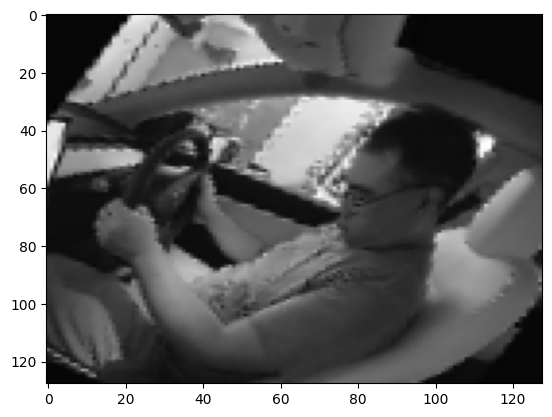

In [84]:
for data_batch,label_batch in train_generator:
    print(data_batch.shape) 
    print(label_batch.shape) 
    break

batch_x, batch_y = next(train_generator)
print(batch_x.shape, batch_x.min(), batch_x.max())
plt.imshow(np.squeeze(batch_x[0]), cmap='gray', aspect='auto')
plt.show()

In [85]:
#cpu handle random dropout cuz issue with CUDA
import tensorflow as tf
from keras.layers import Dropout

class CPUDropout(Dropout):
    def call(self, inputs, training=None):
        with tf.device('/CPU:0'):
            return super().call(inputs, training=training)


In [86]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


model = Sequential([
    # Block 1
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(None, None, 1)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.05),

    # Block 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.1),

    # Block 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.2),

    # Block 4
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Block 5
    Conv2D(512, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    # Classifier Head
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.summary() # to print summary of model architecture

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0),
    metrics=['accuracy']
)

# #convert grayscale
# def to_rgb(x):
#     return tf.image.grayscale_to_rgb(x)

# #use mobilenet, transfer learning
# inputs = Input(shape=(None, None, 1)) 
# x = tf.keras.layers.Lambda(to_rgb)(inputs)
# base_model = MobileNetV2(
#     input_shape=(None, None, 3),
#     include_top=False,
#     weights='imagenet'
# )

# #unfreeze last 15 layers
# base_model.trainable = True
# for layer in base_model.layers[:-20]:
#     layer.trainable = False

# #custom classifier
# x = tf.keras.layers.Lambda(to_rgb)(inputs)
# x = base_model(x, training=False)
# x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.65)(x)
# x = Dense(128, activation='relu', kernel_regularizer=l2(0.0005))(x)
# x = Dropout(0.5)(x)
# outputs = Dense(train_generator.num_classes, activation='softmax')(x)

# model = Model(inputs, outputs)

# #yay
# model.compile(
#     optimizer=AdamW(learning_rate=5e-5, weight_decay=1e-4),
#     loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
#     metrics=['accuracy']
# )

# model.summary()


/home/lurpd/Development/DistractionAI/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, None, None, 32) │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, None, None, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, None, None, 64) │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, None, None,     │         1,024 │
│ (BatchNormalization)            │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, None, None,     │         2,048 │
│ (BatchNormalization)            │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, None, None,     │             

 Total params: 1,705,091 (6.50 MB)

 Trainable params: 1,702,595 (6.49 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [87]:
#autocalculate class weight
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_indices = train_generator.class_indices
num_classes = len(class_indices)
class_labels = np.unique(train_generator.classes)

weights = compute_class_weight(
    class_weight="balanced",
    classes=class_labels,
    y=train_generator.classes
)

class_weights = dict(enumerate(weights))

print("\nAuto-calculated class weights:")
for i, w in class_weights.items():
    class_name = list(class_indices.keys())[i]
    print(f"  {i} ({class_name}): {w:.3f}")

# manual weights just in case
# class_weights = {
#     0: 1.2,  #Safe driving
#     1: 0.7,  #distracted
#     2: 0.1,  #tired
# }


Auto-calculated class weights:
  0 (c0): 1.000
  1 (c1): 1.000
  2 (c2): 1.000


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#stop training if too much loss or plateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

steps_per_epoch = len(train_generator) 
validation_steps = len(val_generator)  

#first training
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weights
)

#start training
# history = model.fit(
#     train_generator,
#     epochs=15,
#     validation_data=val_generator,
#     class_weight=class_weights,
#     steps_per_epoch=steps_per_epoch,
#     validation_steps=validation_steps,
#     callbacks=callbacks
# )

/home/lurpd/Development/DistractionAI/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


In [ ]:
#fine tune
model.optimizer.learning_rate = 1e-5

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    ]
)


Epoch 1/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 63s 107ms/step - accuracy: 0.9079 - loss: 0.2408 - val_accuracy: 0.8474 - val_loss: 0.5499 - learning_rate: 1.0000e-05
Epoch 2/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 63s 107ms/step - accuracy: 0.9087 - loss: 0.2368 - val_accuracy: 0.8284 - val_loss: 0.5938 - learning_rate: 1.0000e-05
Epoch 3/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 63s 107ms/step - accuracy: 0.9120 - loss: 0.2342 - val_accuracy: 0.8326 - val_loss: 0.6050 - learning_rate: 1.0000e-05
Epoch 4/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 62s 106ms/step - accuracy: 0.9103 - loss: 0.2312 - val_accuracy: 0.8371 - val_loss: 0.5768 - learning_rate: 5.0000e-06
Epoch 5/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 63s 107ms/step - accuracy: 0.9130 - loss: 0.2302 - val_accuracy: 0.8347 - val_loss: 0.5902 - learning_rate: 5.0000e-06


In [ ]:
model.save("distracted_driver_detection.keras")

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes

print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))

148/148 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step
              precision    recall  f1-score   support

          c0       0.26      0.35      0.29      2467
          c1       0.54      0.42      0.47      5052
          c2       0.21      0.23      0.22      1895

    accuracy                           0.36      9414
   macro avg       0.33      0.33      0.33      9414
weighted avg       0.40      0.36      0.38      9414



In [ ]:
tr_loss = history.history['loss']
tr_accuracy = history.history['accuracy']

val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

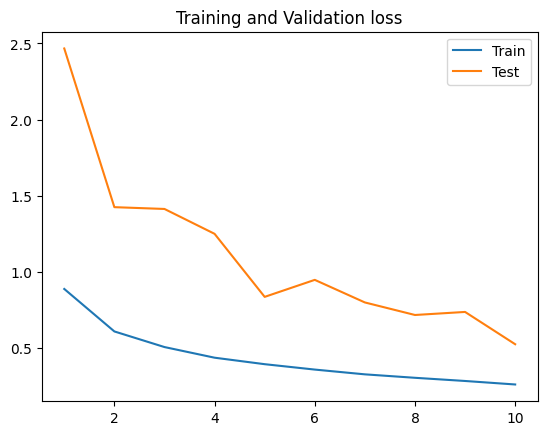

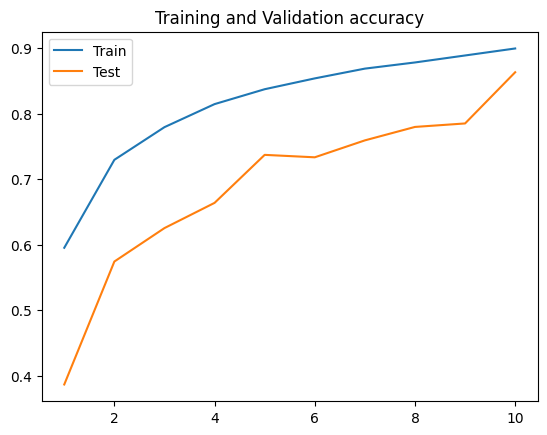

In [ ]:
#graph training results
epchs = list(range(1,len(tr_loss)+1))
plt.plot(epchs,tr_loss,label='Train')
plt.plot(epchs,val_loss,label='Test')
plt.title("Training and Validation loss")
plt.legend()
plt.show()


plt.plot(epchs,tr_accuracy,label='Train')
plt.plot(epchs,val_accuracy,label='Test')
plt.title("Training and Validation accuracy")
plt.legend()
plt.show()

Saved predictions grid to predictions_grid.png


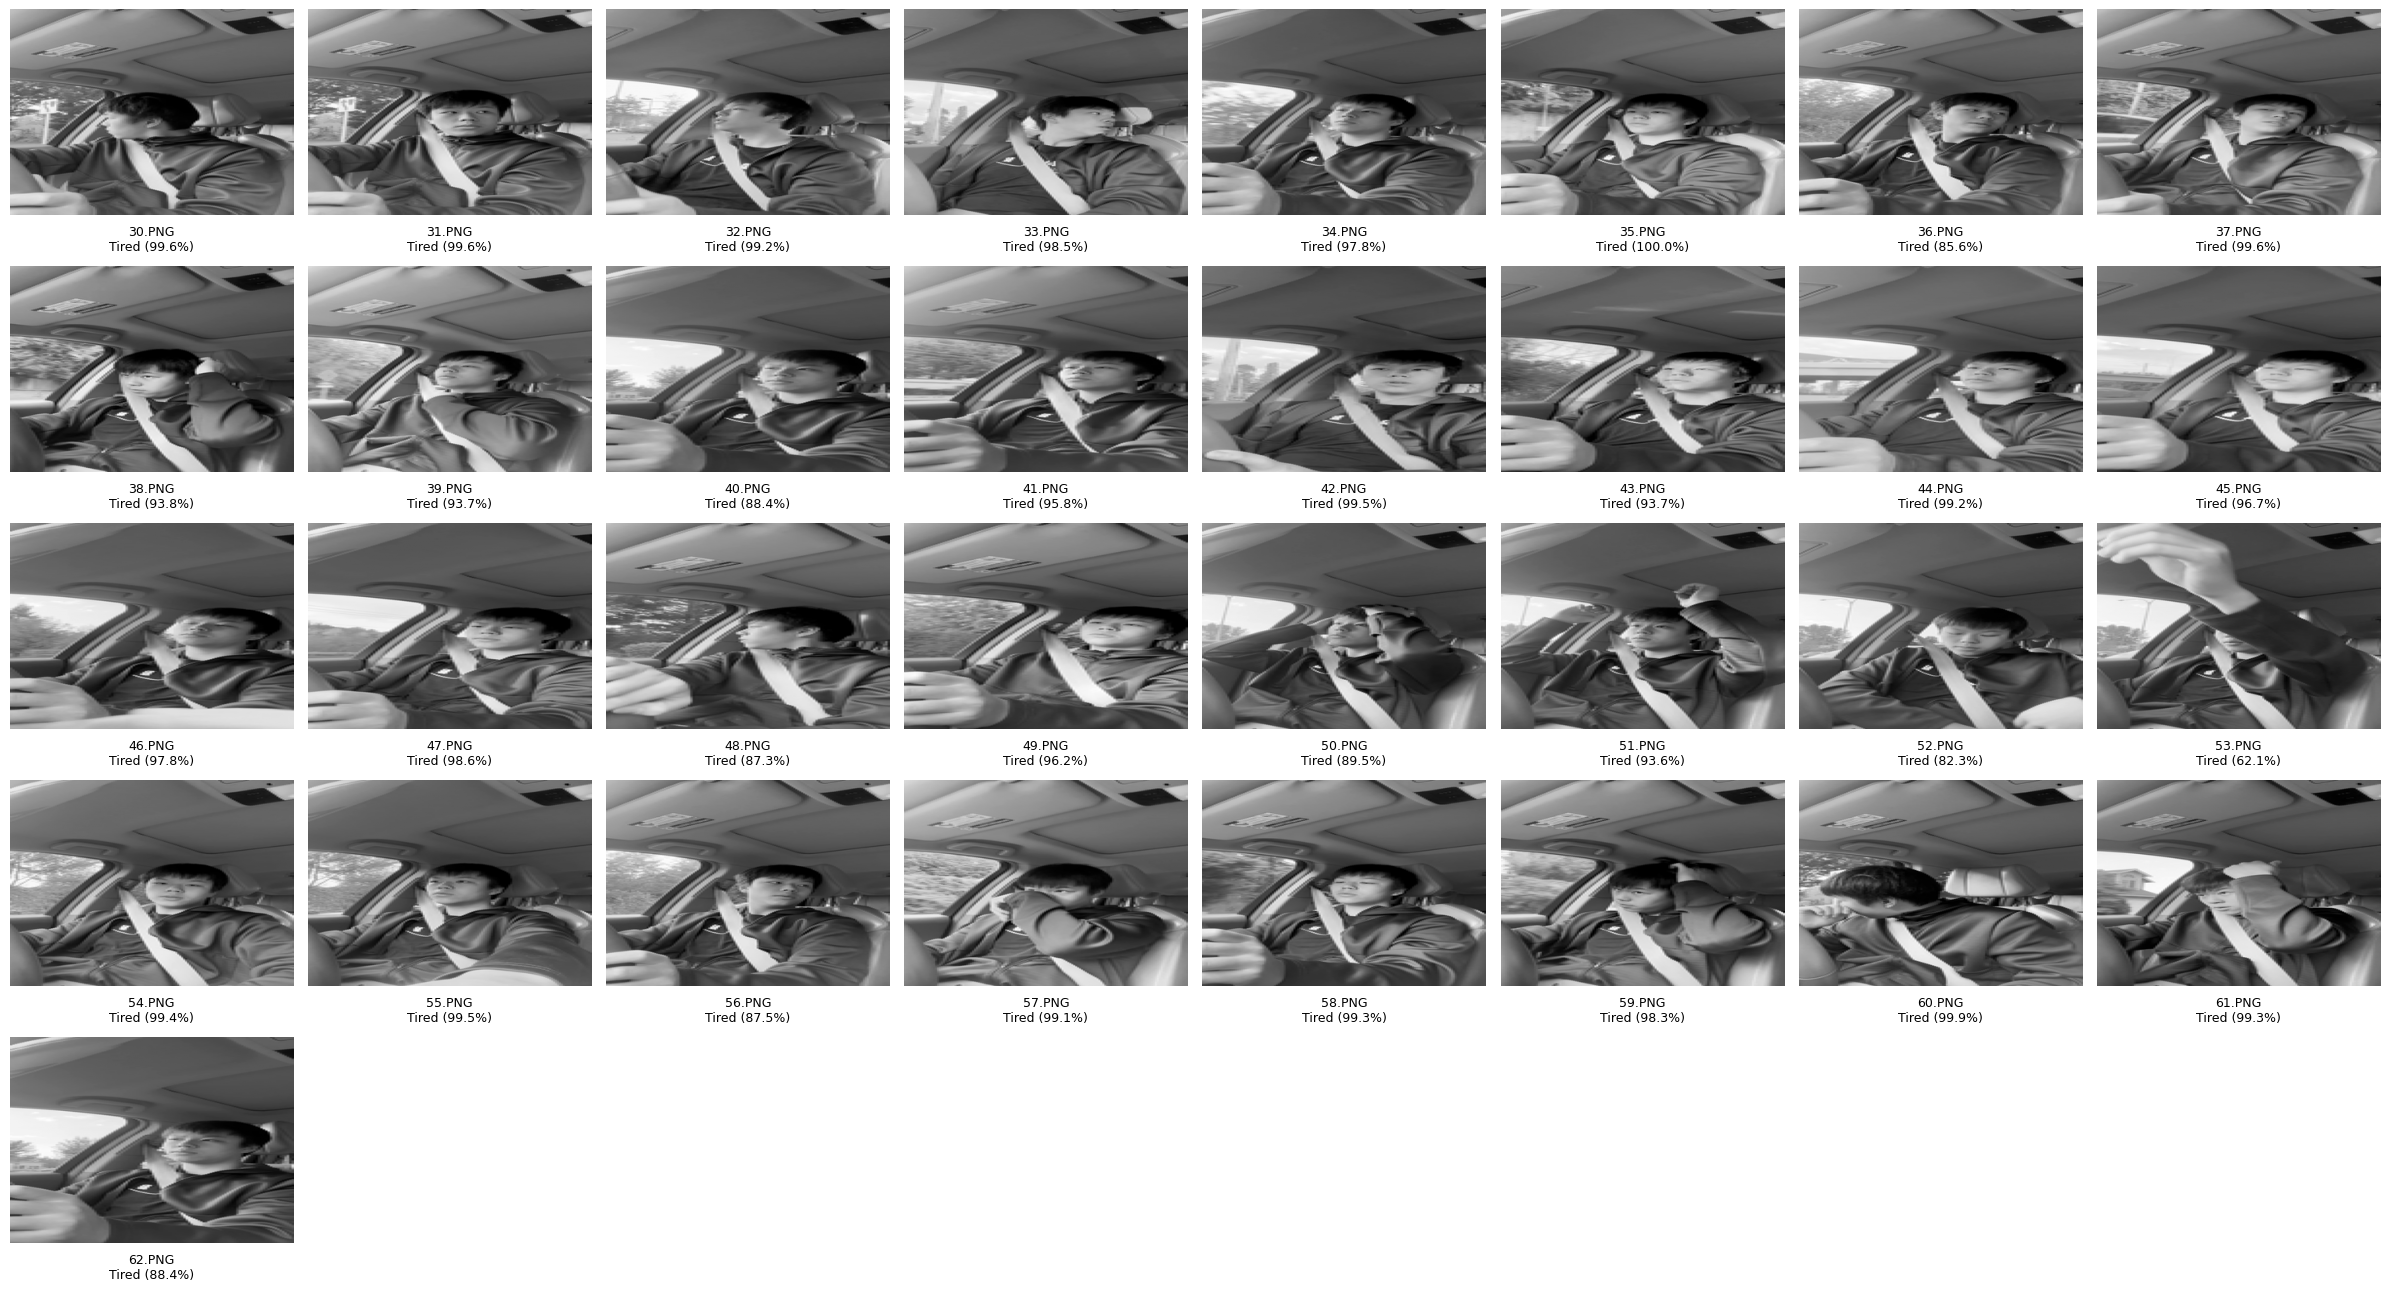

In [ ]:
# test model with real data and show results
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import os
import math

def to_rgb(x):
    return tf.image.grayscale_to_rgb(x)

model = load_model("distracted_driver_detection.keras",
    custom_objects={
        "CPUDropout": Dropout,
        "to_rgb": to_rgb
    })

class_names = ["Safe driving", "Distracted", "Tired"]

folder = "/home/lurpd/Development/Datasets/MyData/"
target_size=(MAX_SIZE, MAX_SIZE)

image_paths = []
for i in range(30, 63):
    for ext in [".png", ".PNG", ".jpg", ".JPG", ".jpeg", ".JPEG"]:
        candidate = os.path.join(folder, f"{i}{ext}")
        if os.path.exists(candidate):
            image_paths.append(candidate)
            break  

cols = 8
rows = math.ceil(len(image_paths) / cols)
max_width_px = 2500
max_height_px = 1300
dpi = 100
fig_width = min(max_width_px / dpi, cols * 3)
fig_height = min(max_height_px / dpi, rows * 3)
plt.figure(figsize=(fig_width, fig_height), dpi=dpi)

for idx, img_path in enumerate(image_paths):
    img = Image.open(img_path).convert("L")
    img.thumbnail((256, 256), Image.Resampling.LANCZOS)
    img_array = np.expand_dims(np.array(img).astype(np.float32) / 255.0, axis=(0, -1))

    predictions = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = class_names[predicted_class]
    confidence = np.max(predictions) * 100

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(np.squeeze(img), cmap='gray', aspect='auto')
    plt.axis("off")
    plt.text(
        0.5, -0.05,
        f"{os.path.basename(img_path)}\n{predicted_label} ({confidence:.1f}%)",
        fontsize=9,
        ha="center", va="top",
        transform=plt.gca().transAxes
    )

plt.tight_layout()
plt.draw()

output_path = "predictions_grid.png"
plt.savefig(output_path, dpi=150, bbox_inches="tight")
print(f"Saved predictions grid to {output_path}")

try:
    if os.path.exists("/mnt/c/Windows"):
        os.system(f"explorer.exe {output_path.replace('/', '\\\\')}")
    else:
        os.system(f"xdg-open {output_path}")
except Exception as e:
    print(f"Could not auto-open image: {e}")
